### DSSD - energy calibration

#### alpha Data 
Location: data/RIBLL2018_16C/alphaCaliFile/t0alpha.root  @course server

Detectors: Three BB7 DSSDs(32x32, 2mm/strip): t0d1,t0d2,t0d3

 $\alpha-$Sources: $^{239}Pu, ^{241}Am, ^{244}Cm$ 

Tree Branch: t0d1x[32], t0d1y[32], t0d2x[32], t0d2y[32], t0d3x[32],t0d3y[32]

![](alpha.png)

### 步骤
0. 将ADC的谱进行连续化。(下面示例中没有进行这一步)
1. 对三个主要峰位进行估计(利用TSpectrum)，利用峰位估计值进行粗刻度。
2. 选取合理的拟合区间，对每个峰进行双高斯拟合(拟合低能部分形状)，得到最终刻度系数。

#### peaks.C --利用TSpectrum寻找histogram中的峰位，并进行标注。
```cpp
TH1F *h=NULL,*hb=NULL;
Int_t nfound;
Double_t *xpeaks=NULL, *ypeaks=NULL;
TSpectrum *s=NULL;
void peaks(TString hname, Double_t thres=0.05,int backsub=1)
{
  h=(TH1F*)gROOT->FindObject(hname);
  if(!s) s=new TSpectrum(500);
  if(backsub) {
    hb=(TH1F*)s->Background(h,80,"same");
    h->Add(h,hb,1,-1);   
  }
  nfound=s->Search(h,2,"",thres); 
  TPolyMarker *pm=(TPolyMarker *)
    h->GetListOfFunctions()->FindObject("TPolyMarker");
  pm->SetMarkerStyle(32);
  pm->SetMarkerColor(kGreen);
  pm->SetMarkerSize(0.4);
  xpeaks=s->GetPositionX();
  ypeaks=s->GetPositionY();
  for(int j=0;j<nfound;j++) {
    stringstream ss;
    ss<<xpeaks[j];
    TString s1=ss.str();
    TLatex *tex=new TLatex(xpeaks[j],ypeaks[j],s1);
    cout<<xpeaks[j]<<endl;
    tex->SetTextFont(13);
    tex->SetTextSize(14);
    tex->SetTextAlign(12);
    tex->SetTextAngle(90);
    tex->SetTextColor(kGreen);
    tex->Draw();
  }
}
```

In [1]:
TFile *f=new TFile("t0alpha.root");
TTree *tree=(TTree*) f->Get("tree");
TCanvas *c1=new TCanvas();


In [2]:
tree->Draw("t0d3x[16]>>h1(200,200,400)");

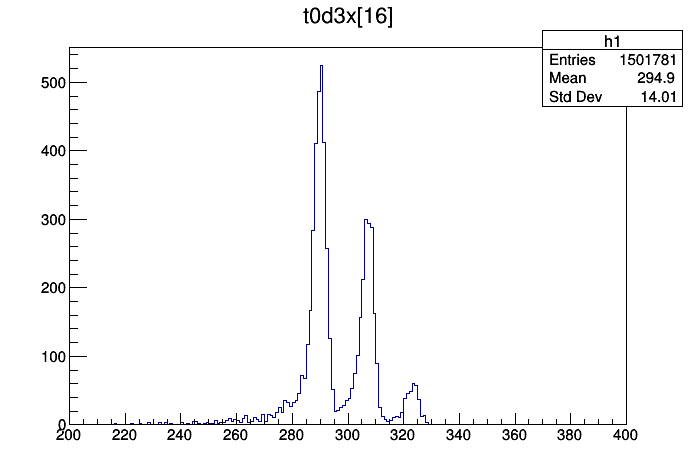

In [3]:
c1->Draw();

In [4]:
.L peaks.C 

In [5]:
peaks("h1");//参数为histogram的名称

289.5
307.5
323.5


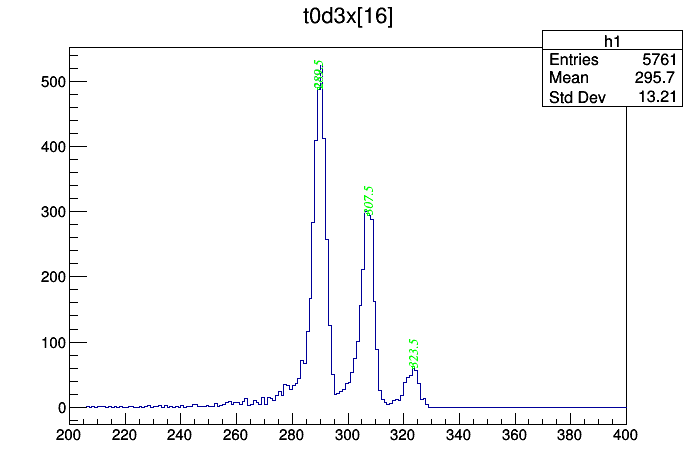

In [6]:
c1->Draw();

In [7]:
double xx[3];
double par[9];
Double_t epeaks[3]={5.156,5.486,5.805};

289.901
307.143
322.967


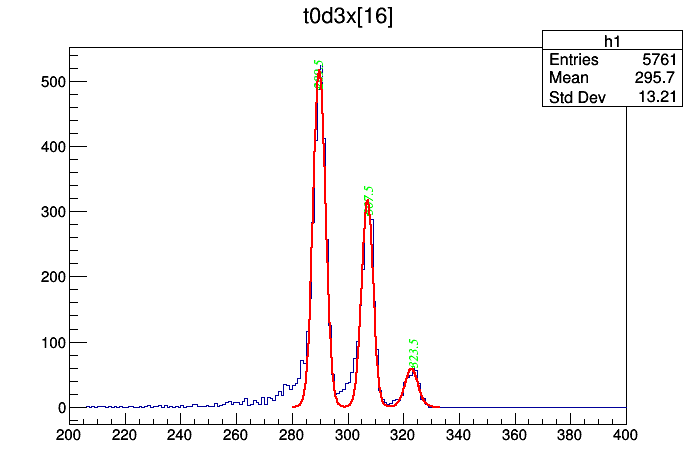

In [8]:
TF1 *fg=new TF1("fg","gaus");
for(int i=0;i<3;i++) {
    fg->SetParameters(ypeaks[i],xpeaks[i],3);//constant, mean, sigma
    h1->Fit(fg,"Q","",xpeaks[i]-3,xpeaks[i]+4);
    xx[i]=fg->GetParameter(1);
    fg->GetParameters(&par[i*3]);
    cout<<xx[i]<<endl;
}
TF1 *fg3=new TF1("fg3","gaus(0)+gaus(3)+gaus(6)",xx[0]-10,xx[2]+10);
fg3->SetParameters(par);
fg3->Draw("same");
c1->Draw();

In [9]:
TGraph *gp=new TGraph(3,xx,epeaks);
TF1 *fp=new TF1("fp","pol1");

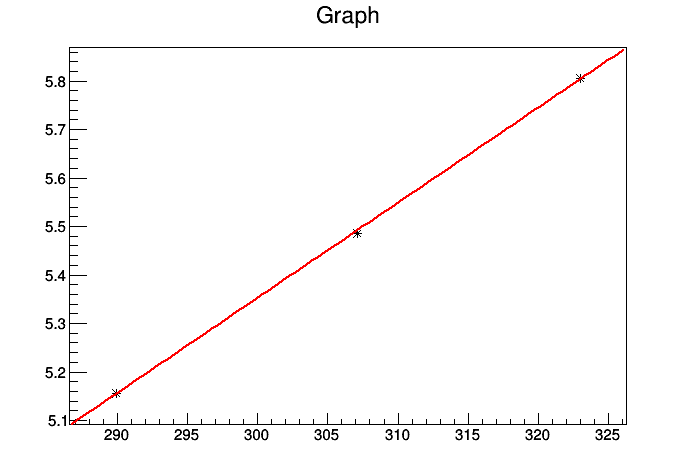


****************************************
Minimizer is Linear
Chi2                      =  4.72203e-05
NDf                       =            1
p0                        =    -0.534606   +/-   0.0901901   
p1                        =    0.0196202   +/-   0.00029381  


In [10]:
gp->Fit(fp);
gp->Draw("AP*");
c1->Draw();

In [11]:
double p0=fp->GetParameter(0);
double p1=fp->GetParameter(1);
TH1F *h2=new TH1F("h2","calibrated alpha spectrum",40,5,6);

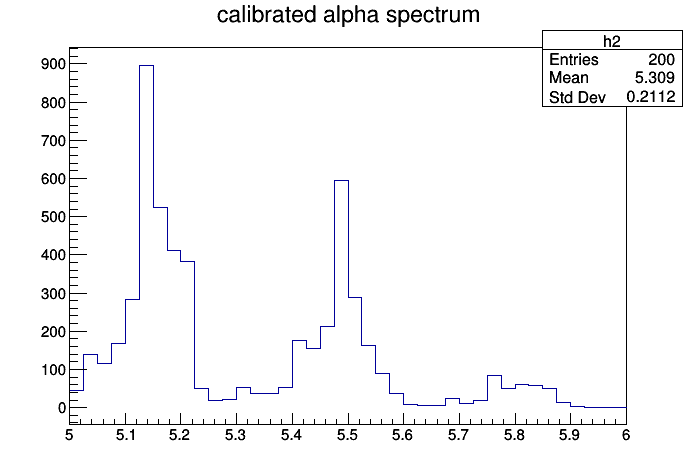

In [12]:
for(int i=1; i<=h1->GetNbinsX();i++) {
    double x=h1->GetBinCenter(i);
    double y=h1->GetBinContent(i);
    h2->Fill(p0+p1*x,y);
}
h2->Sumw2(0);
h2->Draw();//由于进行连续化，刻度后的histogram的形状不正确
c1->Draw();